# Hashtables

## Agenda

- Discussion: pros/cons of array-backed and linked structures
- Python's other built-in DS: the `dict`
- A naive lookup DS
- Direct lookups via *Hashing*
- Hashtables
    - Collisions and the "Birthday problem"
- Runtime analysis & Discussion

## Discussion: pros/cons of array-backed and linked structures

Between the array-backed and linked list we have:

1. $O(1)$ indexing (array-backed)
2. $O(1)$ appending (array-backed & linked)
3. $O(1)$ insertion/deletion without indexing (linked)
4. $O(\log N)$ binary search, when sorted (array-backed)

## Python's other built-in DS: the `dict`

In [61]:
import timeit

def lin_search(lst, x):
    for i in range(len(lst)):
        if lst[i] == x:
            return i
    raise ValueError(x)
    
def bin_search(lst, x):
    # assume that lst is sorted!!!
    low = 0
    hi  = len(lst)
    mid = (low + hi) // 2
    while lst[mid] != x and low <= hi:
        if lst[mid] < x:
            low = mid + 1
        else:
            hi  = mid - 1
        mid = (low + hi) // 2
    if lst[mid] == x:
        return mid
    else:
        raise ValueError(x)

def time_lin_search(size):
    return timeit.timeit('lin_search(lst, random.randrange({}))'.format(size), # interpolate size into randrange
                         'import random ; from __main__ import lin_search ;'
                         'lst = [x for x in range({})]'.format(size), # interpolate size into list range
                         number=100)

def time_bin_search(size):
    return timeit.timeit('bin_search(lst, random.randrange({}))'.format(size), # interpolate size into randrange
                         'import random ; from __main__ import bin_search ;'
                         'lst = [x for x in range({})]'.format(size), # interpolate size into list range
                         number=100)

def time_dict(size):
    return timeit.timeit('dct[random.randrange({})]'.format(size), 
                         'import random ; '
                         'dct = {{x: x for x in range({})}}'.format(size),
                         number=100)

lin_search_timings = [time_lin_search(n)
                      for n in range(10, 10000, 100)]

bin_search_timings = [time_bin_search(n)
                      for n in range(10, 10000, 100)]

dict_timings = [time_dict(n)
                for n in range(10, 10000, 100)]

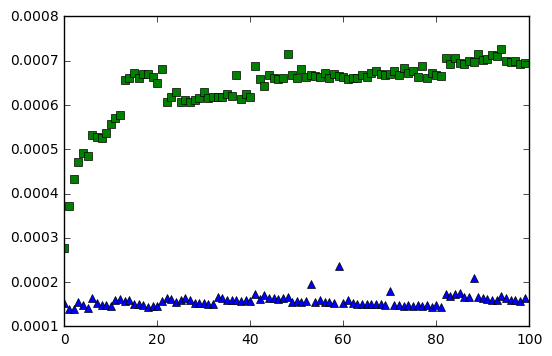

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.plot(lin_search_timings, 'ro')
plt.plot(bin_search_timings, 'gs')
plt.plot(dict_timings, 'b^')
plt.show()

## A naive lookup DS
"Associative list DS" A bunch of lists that associate keys and values

In [63]:
class LookupDS: # a dictionary adt implementation
    def __init__(self):
        self.data = []
    
    def __setitem__(self, key, value):
        for i in range(len(self.data)):
            if self.data[i][0] == key:
                self.data[i][1] = value
                break
        else:
            self.data.append([key, value])
    
    def __getitem__(self, key):
        for k, v in self.data:
            if k == key:
                return v
        else:
            raise KeyError(key)

    def __repr__(self):
        return '{ ' + ', '.join('{}: {}'.format(k,v) for k,v in self.data) + ' }'
    
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [64]:
key = [1, 2, 3]
d = LookupDS()
d[key] = 'world'
d

{ [1, 2, 3]: world }

In [65]:
key.append(4) #This is changing the key

In [66]:
d[[1,2,3]]

KeyError: [1, 2, 3]

In [67]:
d

{ [1, 2, 3, 4]: world }

In [68]:
d = {}
key = [1, 2, 3]
d[key] = "hello"

TypeError: unhashable type: 'list'

In [69]:
d = LookupDS()
d['hello'] = 'world'
d['goodbye'] = 'earth'
d

{ hello: world, goodbye: earth }

In [70]:
d['good']

KeyError: 'good'

In [71]:
d['goodbye'] = 'mars'
d

{ hello: world, goodbye: mars }

Demonstrates the relevant APIs, but is 
O(N)
O(N)
for lookup (via __getitem__) operations

## Direct lookups via *Hashing*

Hashes (a.k.a. hash codes or hash values) are simply numerical values computed for objects. Computes number for hashable object.

Hash values are always recomputed based on a certain set of conditions each session, but are constant throughout that session 

In [72]:
hash('hello') #Strings are immutable

-1584126667937826745

In [73]:
 [] is []#Mutable objects have different mem locations

False

In [74]:
[hash(s) for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[6962585990029555725,
 -6067609157852536232,
 3244416615833379409,
 -4724145847316653107,
 6962585990029555725,
 3927472167939964272]

Immutable objects are not remade each time used, therefore are the same things in memory

Note that a given object will always hash to the same value (e.g., the string 'different').

We can use the modulus operator (a.k.a. the remainder operator) to map a hash value to a smaller range.

In [75]:
# reminder of the semantics of the modulus operator
n = 7
for x in range(20):
    print('{} % {} = {}'.format(x, n, x % n))

0 % 7 = 0
1 % 7 = 1
2 % 7 = 2
3 % 7 = 3
4 % 7 = 4
5 % 7 = 5
6 % 7 = 6
7 % 7 = 0
8 % 7 = 1
9 % 7 = 2
10 % 7 = 3
11 % 7 = 4
12 % 7 = 5
13 % 7 = 6
14 % 7 = 0
15 % 7 = 1
16 % 7 = 2
17 % 7 = 3
18 % 7 = 4
19 % 7 = 5


In [76]:
[hash(s) % 100 for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

[25, 68, 9, 93, 25, 72]

## Hashtables
An implementation of "Mapping" ADT
"Mapping ADT"  Maps keys to values, keys are distinguishable, thus if key exsists then can find value, but not other way around because many keys can have the same value

In [77]:
class Hashtable:
    def __init__(self, n_buckets=1000):
        self.buckets = [None] * n_buckets
        
    def __setitem__(self, key, val):
        idx = hash(key) % len(self.buckets)
        self.buckets[idx] = val
    
    def __getitem__(self, key):
        idx = hash(key) % len(self.buckets)
        if self.buckets[idx] is not None:
            return self.buckets[idx]
        else:
            raise KeyError(key)
        
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [78]:
ht = Hashtable(10)

In [79]:
ht['hello'] = 'world'

In [80]:
ht['hello']

'world'

In [81]:
ht.buckets

[None, None, None, None, None, 'world', None, None, None, None]

In [82]:
for i in range(15):
    ht[i] = i*2

In [83]:
for i in range(15): #The hashing of a number is just the number itself
    print(i, '=>', ht[i])

0 => 20
1 => 22
2 => 24
3 => 26
4 => 28
5 => 10
6 => 12
7 => 14
8 => 16
9 => 18
10 => 20
11 => 22
12 => 24
13 => 26
14 => 28


In [84]:
ht.buckets

[20, 22, 24, 26, 28, 10, 12, 14, 16, 18]

## On Collisions

### The "Birthday Problem"

Problem statement: Given 
N
N
people at a party, how likely is it that at least two people will have the same birthday?
This is easiest to calculate by considering the inverse: what is the probability that everyone has a unique birthday?
For 
1
1
person, the probability is 1 (100%).
For 
2
2
people, it is simply the likelihood that the second person is born on any of the other 364 days of the year, i.e., 
364/365

364/365
.
For 
3
3
people, the third person has to be born on one of the remaining 363 days. We combine ("and" together) probabilities by multiplying them, so the likelihood that three people are born on different days is 
1×364/365×363/365

1×364/365×363/365
.
For 
N≤365
N≤365
people, the likelihood that everyone is born on a different day is simply: 
365/365

×
364/365

×⋯×
365−(N−1)/365

365/365×364/365×⋯×365−(N−1)365
Having computed the inverse probability, we can determine how likely it is that two or more people will have the same birthday by simply subtracting the inverse from 1. The function below does this:

In [85]:
def birthday_p(n_people): #We can use this for n number of buckets
    p_inv = 1 
    for n in range(365, 365-n_people, -1):
        p_inv *= n / 365
    return 1 - p_inv

In [86]:
birthday_p(22)

0.4756953076625503

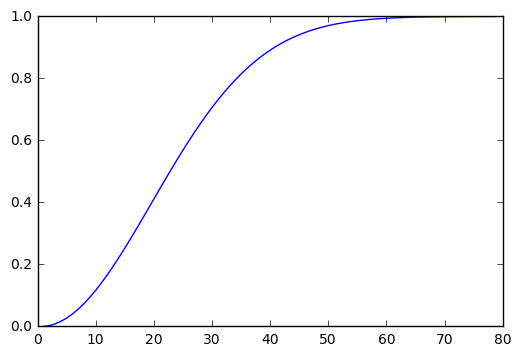

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

n_people = range(1, 80)
plt.plot(n_people, [birthday_p(n) for n in n_people])
plt.show()

### General collision statistics

Repeat the birthday problem, but with a given number of values and "buckets" that are allotted to hold them. How likely is it that two or more values will map to the same bucket?

In [88]:
def collision_p(n_values, n_buckets):
    p_inv = 1
    for n in range(n_buckets, n_buckets-n_values, -1):
        p_inv *= n / n_buckets
    return 1 - p_inv

In [89]:
collision_p(23, 365) # same as birthday problem, for 23 people

0.5072972343239857

In [90]:
collision_p(10, 100)

0.37184349044470544

In [91]:
collision_p(100, 1000)

0.9940410733677595

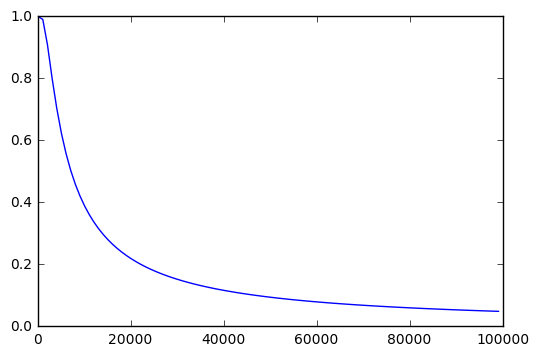

In [92]:
# keeping number of values fixed at 100, but vary number of buckets: visualize probability of collision
%matplotlib inline
import matplotlib.pyplot as plt

n_buckets = range(100, 100001, 1000)
plt.plot(n_buckets, [collision_p(100, nb) for nb in n_buckets])
plt.show()

In [93]:
def avg_num_collisions(n, b):
    """Returns the expected number of collisions for n values uniformly distributed
    over a hashtable of b buckets. Based on (fairly) elementary probability theory.
    (Pay attention in MATH 474!)"""
    return n - b + b * (1 - 1/b)**n

In [94]:
avg_num_collisions(28, 365)

1.011442040700615

In [95]:
avg_num_collisions(1000, 1000)

367.6954247709637

In [96]:
avg_num_collisions(1000, 10000)

48.32893558556316

## Dealing with Collisions

To deal with collisions in a hashtable, we simply create a "chain" of key/value pairs for each bucket where collisions occur. The chain needs to be a data structure that supports quick insertion — natural choice: the linked list!

In [97]:
class Hashtable:
    class Node:
        def __init__(self, key, val, next=None): #Node contains key and value, one dir, not circular
            self.key = key
            self.val = val
            self.next = next
            
    def __init__(self, n_buckets=1000):
        self.buckets = [None] * n_buckets
        
    def __setitem__(self, key, val):
        bucket_idx = hash(key) % len(self.buckets)
        n = self.buckets[bucket_idx]
        while n:
            if n.key == key:
                n.val = val
                break #it down
            n = n.next        
        else:
            #prepend the key/value to the bucket
            self.buckets[bucket_idx] = Hashtable.Node(key, val, self.buckets[bucket_idx])
                
    def __getitem__(self, key):
        bucket_idx = hash(key) % len(self.buckets)
        n = self.buckets[bucket_idx]
        while n:
            if n.key == key:
                return n.val #it down
            n = n.next    
        else:
            raise KeyError(key)
            
    def __contains__(self, key):
        try:
            _ = self[key]
            return True
        except:
            return False

In [98]:
h = Hashtable(1)
h['batman'] = 'bruce wayne'
h['superman'] = 'clark kent'

In [99]:
n = h.buckets[0]
while n:
    print(n.key, n.val)
    n = n.next

superman clark kent
batman bruce wayne


In [105]:
def prep_ht(size):
    ht = Hashtable(size*10)
    for x in range(size):
        ht[x] = x
    return ht

def time_ht(size):
    return timeit.timeit('ht[random.randrange({})]'.format(size), 
                         'import random ; from __main__ import prep_ht ;'
                         'ht = prep_ht({})'.format(size),
                         number=100)

ht_timings = [time_ht(n)
                for n in range(10, 10000, 100)]

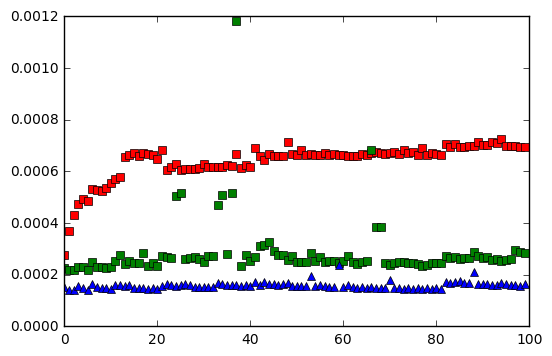

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(bin_search_timings, 'rs')
plt.plot(ht_timings, 'gs')
plt.plot(dict_timings, 'b^')
plt.show()

## Loose ends

### Iteration

In [107]:
d = {}
for i in range(10):
    d[i] = i*2

In [109]:
for k,v in d.items():
    print(k, v)

0 0
1 2
2 4
3 6
4 8
5 10
6 12
7 14
8 16
9 18


In [110]:
class Hashtable(Hashtable):
    def __iter__(self):
        for n in self.buckets:
            #n is either a node or None
            while n:
                yield n.key
                n = n.next

In [114]:
ht = Hashtable()
for i in range(10):
    ht[str(i)] = i*2

In [115]:
for k in ht:
    print(k, ht[k])

4 8
6 12
7 14
9 18
8 16
3 6
1 2
0 0
5 10
2 4


### "Load factor" and Rehashing

It doesn't often make sense to start with a large number of buckets, unless we know in advance that the number of keys is going to be vast — also, the user of the hashtable would typically prefer to not be bothered with implementation details (i.e., bucket count) when using the data structure.

Instead: start with a relatively small number of buckets, and if the ratio of keys to the number of buckets (known as the **load factor**) is above some desired threshold — which we can determine using collision probabilities — we can dynamically increase the number of buckets. This requires, however, that we *rehash* all keys and potentially move them into new buckets (since the `hash(key) % num_buckets` mapping will likely be different with more buckets).

### Other APIs

- FIXED `__setitem__` (to update value for existing key)
- `__delitem__`
- `keys` & `values` (return iterators for keys and values)
- `setdefault`

## Runtime analysis & Discussion

For a hashtable with $N$ key/value entries:

- Insertion: $O(N)$
- Lookup: $O(N)$
- Deletion: $O(N)$

## Vocabulary list

- hashtable
- hashing and hashes
- collision
- hash buckets & chains
- birthday problem
- load factor
- rehashing

---

## Addendum: On *Hashability*

Remember: *a given object must always hash to the same value*. This is required so that we can always map the object to the same hash bucket.

Hashcodes for collections of objects are usually computed from the hashcodes of its contents, e.g., the hash of a tuple is a function of the hashes of the objects in said tuple:

In [116]:
hash(('two', 'strings'))

-748776463667699766

This is useful. It allows us to use a tuple, for instance, as a key for a hashtable.

However, if the collection of objects is *mutable* — i.e., we can alter its contents — this means that we can potentially change its hashcode.`

If we were to use such a collection as a key in a hashtable, and alter the collection after it's been assigned to a particular bucket, this leads to a serious problem: the collection may now be in the wrong bucket (as it was assigned to a bucket based on its original hashcode)!

For this reason, only immutable types are, by default, hashable in Python. So while we can use integers, strings, and tuples as keys in dictionaries, lists (which are mutable) cannot be used. Indeed, Python marks built-in mutable types as "unhashable", e.g.,

In [118]:
hash([1, 2, 3])

TypeError: unhashable type: 'list'

That said, Python does support hashing on instances of custom classes (which are mutable). This is because the default hash function implementation does not rely on the contents of instances of custom classes. E.g.,

In [119]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname

In [120]:
s = Student('John', 'Doe')
hash(s)

-9223371886859625100

In [124]:
s.fname = 'Jane' #Changing component of object doesn't change hash, hash based on memory
hash(s) # same as before mutation

-9223371886859625100

We can change the default behavior by providing our own hash function in `__hash__`, e.g.,

In [125]:
class Student:
    def __init__(self, fname, lname):
        self.fname = fname
        self.lname = lname
        
    def __hash__(self):
        return hash(self.fname) + hash(self.lname)

In [126]:
s = Student('John', 'Doe')
hash(s)

-4319627463202814443

In [127]:
s.fname = 'Jane'
hash(s)

-8846991727949351097

But be careful: instances of this class are no longer suitable for use as keys in hashtables (or dictionaries), if you intend to mutate them after using them as keys!